In [1]:
# Ajustar path para encontrar el módulo src
import sys
from pathlib import Path

current_dir = Path.cwd()
if (current_dir / "src").exists():
    project_root = current_dir
elif (current_dir.parent / "src").exists():
    project_root = current_dir.parent
else:
    project_root = current_dir
    for parent in current_dir.parents:
        if (parent / "src").exists():
            project_root = parent
            break

if (project_root / "src").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))



In [2]:
import os, pandas as pd
from pathlib import Path
from src.config import settings
from src.semanticscholar_client import SemanticScholarClient
from src.etl import (
    search_until_target, fetch_details,
    to_nodes_edges, save_processed, build_summaries
)

# Verificar API key
api_key_loaded = settings.api_key is not None
print(f"API Key cargada: {'✅ Sí' if api_key_loaded else '❌ No'}")
if not api_key_loaded:
    env_path = Path(__file__).parent.parent / ".env" if '__file__' in globals() else Path.cwd().parent / ".env"
    print(f"Buscando .env en: {env_path}")
    if env_path.exists():
        print(f"⚠️ .env existe pero no se cargó. Reinicia el kernel y vuelve a ejecutar.")
    else:
        print(f"⚠️ .env no encontrado en {env_path}")

settings  # muestra config completa



API Key cargada: ✅ Sí


Settings(base_url='https://api.semanticscholar.org/graph/v1', api_key='in2r847PoK7xSf6qEZOat6Q8RcwFiVGZ7k208v9h', timeout=30, max_retries=3)

In [3]:
# Query simplificado - Semantic Scholar 

QUERY = "precision agriculture"

YEAR = "2010-"  # Ampliado para obtener más resultados
PUB_TYPES = "JournalArticle,Conference,Review,Proceedings,Survey"  # Más tipos para mayor volumen
FIELDS_SEARCH = "title,year,url,publicationTypes,publicationDate,openAccessPdf,citationCount"  # Incluye year
FIELDS_DETAILS = (
    "paperId,title,year,abstract,"
    "citationCount,influentialCitationCount,"
    "authors,externalIds,url,"
    "publicationTypes,venue,"
    "fieldsOfStudy,"
    "references.paperId"

)
TARGET = 1000  # Objetivo de papers a obtener
MAX_PAGES = 30  # Protección contra loops infinitos
SORT = "publicationDate"  # Ordenar por fecha de publicación

print(f"Query: {QUERY}")
print(f"Año: {YEAR}")
print(f"Tipos: {PUB_TYPES}")
print(f"Target: {TARGET} papers")


Query: precision agriculture
Año: 2010-
Tipos: JournalArticle,Conference,Review,Proceedings,Survey
Target: 1000 papers


In [4]:
client = SemanticScholarClient()
df_search = search_until_target(
    client=client,
    query=QUERY,
    year=YEAR,
    publication_types=PUB_TYPES,
    fields=FIELDS_SEARCH,
    sort=SORT,
    target=TARGET,
    max_pages=MAX_PAGES
)
df_search.shape



🔍 Iniciando búsqueda: target=1000, max_pages=30
   Query: precision agriculture...
   Year: 2010-, Types: JournalArticle,Conference,Review,Proceedings,Survey
   Página 1: 1000 papers recibidos, 0 únicos acumulados
   Total encontrado por API: 20899
✅ Búsqueda completada: 1000 papers únicos obtenidos en 1 páginas


(1000, 8)

In [5]:
df_search.shape, df_search.head(10)



((1000, 8),
                                     paperId  \
 0  14bb7289a39918bc7f0511d1a1f711ce18ee0496   
 1  311e8edb636278d4b8c8d03010b56cc53f8b2a05   
 2  c16832dde0ab4a91e54649053d211591c71aea94   
 3  33c834f48f7ef89f275833a7af45c6c6a6747b81   
 4  6e54db2c2e22a07bb6c8ca0c9c492eb5a98d33f0   
 5  dfafa54415164d92d671e078c45d94a6ded7d560   
 6  3f74f6417111a26b295797b44db7800e74e67dd7   
 7  31276d9155c9136574fa9100396f968375d2845f   
 8  2e09243ca57bc5af34c49f45c7f71d69d9f6f44e   
 9  b12f84361189629226ec1fa9e5b254a5001cbbf8   
 
                                                title  year publicationDate  \
 0  Assessing On-Farm Irrigation Water Use Efficie...  2010      2010-01-01   
 1  New evaluation method to detect physiological ...  2010      2010-01-03   
 2  The Modeling and Dynamic Simulation of a Spati...  2010      2010-01-22   
 3                  Radiometric Calibration for AgCam  2010      2010-02-01   
 4  Development of a Sample Preparation Method for...  2010    

In [6]:
# Tomar EXACTAMENTE 1000 paperIds de df_search
paper_ids = df_search["paperId"].dropna().drop_duplicates().tolist()
if len(paper_ids) < 1000:
    raise ValueError(f"Solo hay {len(paper_ids)} candidatos; aumenta el target o relaja filtros.")
subset_ids = paper_ids[:1000]  # 1000 exactos
print(f"✅ {len(subset_ids)} paperIds seleccionados para descargar detalles")
len(subset_ids), subset_ids[:3]



✅ 1000 paperIds seleccionados para descargar detalles


(1000,
 ['14bb7289a39918bc7f0511d1a1f711ce18ee0496',
  '311e8edb636278d4b8c8d03010b56cc53f8b2a05',
  'c16832dde0ab4a91e54649053d211591c71aea94'])

In [7]:
# 1ª pasada: descarga inicial
details = fetch_details(
    client=client,
    paper_ids=subset_ids,
    fields=FIELDS_DETAILS
)

# Identificar fallidos para reintento
ok_ids = {d.get("paperId") for d in details if d.get("paperId")}
failed_ids = [pid for pid in subset_ids if pid not in ok_ids]

print(f"\n📊 Resumen 1ª pasada: {len(details)} OK, {len(failed_ids)} fallidos")

# 2ª pasada: reintentos con backoff suave
if failed_ids:
    import random
    import time
    from tqdm import tqdm
    
    print(f"🔄 Reintentando {len(failed_ids)} papers fallidos...")
    retry_details = []
    
    for pid in tqdm(failed_ids, desc="Retrying failed details"):
        r = client.get_paper_details(pid, FIELDS_DETAILS)
        if r.status_code == 200 and isinstance(r.data, dict):
            retry_details.append(r.data)
            # Guardar también en JSON
            from pathlib import Path
            import json
            details_dir = Path("data/raw/details")
            details_dir.mkdir(parents=True, exist_ok=True)
            (details_dir / f"{pid}.json").write_text(
                json.dumps(r.data, ensure_ascii=False, indent=2)
            )
        elif r.status_code == 429:
            time.sleep(1)  # Esperar más en rate limit
        time.sleep(0.25 + random.random() * 0.25)  # 250–500 ms
    
    details.extend(retry_details)
    print(f" Detalles totales tras retry: {len(details)} / 1000")

len(details)



📥 Descargando detalles de 1000 papers...


Fetching paper details:  27%|██▋       | 270/1000 [04:45<34:09,  2.81s/it]

⚠️ Error en fae55d035bd11ec4549f1a2b5eb65fcb50c3736f: status=0, error=Unknown error


Fetching paper details:  64%|██████▍   | 640/1000 [11:18<18:01,  3.00s/it]

⚠️ Error en e2787339e0dc2add5f661e503bfb108edea07057: status=0, error=Unknown error


Fetching paper details:  98%|█████████▊| 980/1000 [17:15<00:57,  2.87s/it]

⚠️ Error en 7d725caa0683c6f925b6d304c64e5fec22b86826: status=0, error=Unknown error


Fetching paper details: 100%|██████████| 1000/1000 [17:31<00:00,  1.05s/it]


⚠️ Total de errores: 3 de 1000
✅ Detalles obtenidos: 997 de 1000

📊 Resumen 1ª pasada: 997 OK, 3 fallidos
🔄 Reintentando 3 papers fallidos...


Retrying failed details: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

 Detalles totales tras retry: 1000 / 1000


1000

In [8]:
dfs = to_nodes_edges(details)
for k, v in dfs.items():
    print(k, v.shape)

# Crear nodos stub para targets citados que no están en 'papers'
papers_df = dfs["papers"]
edges_cites = dfs["paper_cites_paper"]

in_nodes = set(papers_df["paperId"])
targets = set(edges_cites["targetPaperId"])
missing_targets = sorted(list(targets - in_nodes))

if missing_targets:
    stub_rows = [{"paperId": t, "title": None, "abstract": None, "year": None,
                  "citationCount": None, "influentialCitationCount": None,
                  "doi": None, "url": None, "publicationTypes": None, "venue": None}
                 for t in missing_targets]
    papers_df = pd.concat([papers_df, pd.DataFrame(stub_rows)], ignore_index=True)\
                   .drop_duplicates(subset=["paperId"])
    dfs["papers"] = papers_df
    print(f"\n📌 Stubs añadidos: {len(missing_targets)} (para mantener conexiones del grafo)")
    print(f"   Total papers (con stubs): {len(dfs['papers'])}")
else:
    print("\nTodos los targets citados están en papers (no se necesitan stubs)")

save_processed(dfs)
sorted(list(dfs.keys()))



papers (1000, 10)
authors (3409, 3)
venues (446, 2)
fields (17, 1)
paper_authoredby_author (3831, 2)
paper_publishedin_venue (786, 2)
paper_has_topic (1349, 2)
paper_cites_paper (6328, 2)

📌 Stubs añadidos: 5772 (para mantener conexiones del grafo)
   Total papers (con stubs): 6772


['authors',
 'fields',
 'paper_authoredby_author',
 'paper_cites_paper',
 'paper_has_topic',
 'paper_publishedin_venue',
 'papers',
 'venues']


=== summary_year_counts ===


,year,count
0,2010,115
1,2011,139
2,2012,145
3,2013,147
4,2014,200
5,2015,237
6,2016,17



=== summary_top_venues ===


,venueId,name,papers
119,Conference on Control Technology and Applications,Conference on Control Technology and Applications,39
328,Italian National Conference on Sensors,Italian National Conference on Sensors,31
162,Guang pu xue yu guang pu fen xi = Guang pu,Guang pu xue yu guang pu fen xi = Guang pu,22
396,Precision Agriculture,Precision Agriculture,18
226,International Conference on Agro-Geoinformatics,International Conference on Agro-Geoinformatics,16
410,Remote Sensing,Remote Sensing,15
187,IEEE International Geoscience and Remote Sensi...,IEEE International Geoscience and Remote Sensi...,14
385,PLoS ONE,PLoS ONE,12
338,Journal of Agricultural and Food Chemistry,Journal of Agricultural and Food Chemistry,9
441,Workshop on Hyperspectral Image and Signal Pro...,Workshop on Hyperspectral Image and Signal Pro...,9



=== summary_top_authors ===


,authorId,name,papers
815,1739594,Wenjiang Huang,11
739,1679742,G. Pajares,8
863,1792073,Minzan Li,6
945,1953258,Y. Miao,6
2644,46878887,Guifen Chen,6
2429,37345377,A. N. Harun,5
3305,92330396,Xiaofei An,5
2682,47366436,Herman Sahota,5
924,1909719357,Ratnesh Kumar,5
2097,3034297,Liying Cao,5



=== Distribución por publicationTypes ===


,count
JournalArticle,541
Review,362
Conference,276
Study,26
Book,3
Editorial,2
LettersAndComments,2
MetaAnalysis,1



=== Top papers por influentialCitationCount ===


,title,influentialCitationCount,year
69,Fundamentals of Wireless Sensor Networks: Theo...,41,2010
320,The application of small unmanned aerial syste...,37,2012
710,Estimating Biomass of Barley Using Crop Surfac...,35,2014
796,Evaluating Multispectral Images and Vegetation...,32,2015
389,IT as enabler of sustainable farming: An empir...,30,2012
782,Importance of Genetic Diversity Assessment in ...,30,2015
987,Plant Disease Detection by Imaging Sensors - P...,29,2016
8,Precision Agriculture and Food Security,26,2010
313,Factors influencing the adoption of precision ...,23,2012
414,Advances in Remote Sensing of Agriculture: Con...,19,2013


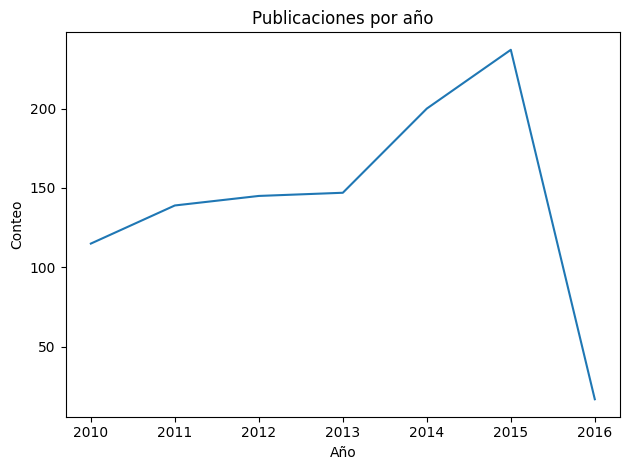

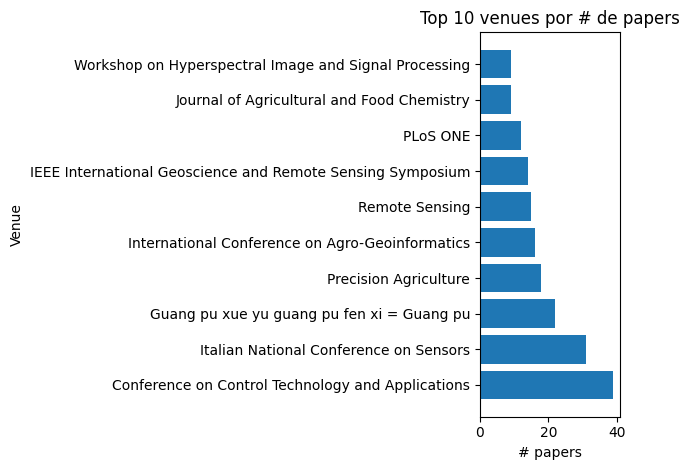

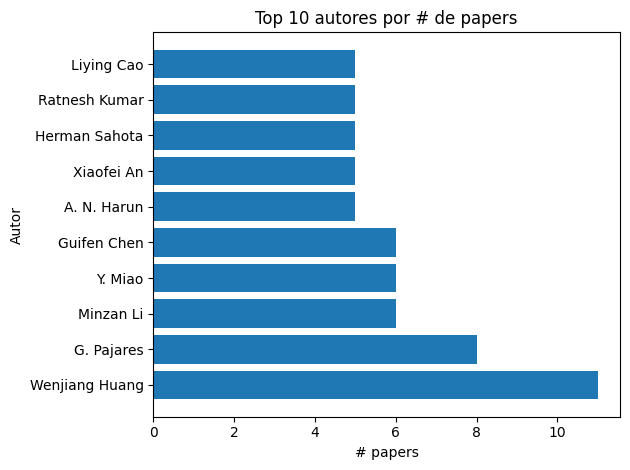

In [9]:
import matplotlib.pyplot as plt

summaries = build_summaries(dfs)

# Tablas resumen rápidas
for k, v in summaries.items():
    print(f"\n=== {k} ===")
    display(v.head(10))

# Resúmenes adicionales
if not df_search.empty and "publicationTypes" in df_search.columns:
    print("\n=== Distribución por publicationTypes ===")
    pubtypes = df_search["publicationTypes"].str.get_dummies(sep=",").sum().sort_values(ascending=False)
    display(pubtypes.to_frame("count").head(10))

if not dfs["papers"].empty and "influentialCitationCount" in dfs["papers"].columns:
    print("\n=== Top papers por influentialCitationCount ===")
    top_influential = dfs["papers"][["title", "influentialCitationCount", "year"]].dropna(subset=["influentialCitationCount"])\
        .sort_values("influentialCitationCount", ascending=False).head(20)
    display(top_influential)

# Gráficas
if "summary_year_counts" in summaries and not summaries["summary_year_counts"].empty:
    s = summaries["summary_year_counts"].sort_values("year")
    plt.figure()
    plt.plot(s["year"], s["count"])
    plt.title("Publicaciones por año")
    plt.xlabel("Año")
    plt.ylabel("Conteo")
    plt.tight_layout()
    plt.show()

if "summary_top_venues" in summaries and not summaries["summary_top_venues"].empty:
    s = summaries["summary_top_venues"].head(10)
    plt.figure()
    plt.barh(s["name"], s["papers"])
    plt.title("Top 10 venues por # de papers")
    plt.xlabel("# papers")
    plt.ylabel("Venue")
    plt.tight_layout()
    plt.show()

if "summary_top_authors" in summaries and not summaries["summary_top_authors"].empty:
    s = summaries["summary_top_authors"].head(10)
    plt.figure()
    plt.barh(s["name"], s["papers"])
    plt.title("Top 10 autores por # de papers")
    plt.xlabel("# papers")
    plt.ylabel("Autor")
    plt.tight_layout()
    plt.show()



In [10]:
print("=== COBERTURA ===")
print("Candidatos (search):", len(df_search))
print("Detalles (descargados):", len(details), " >= 1000 ?", len(details) >= 1000)

print("\n=== CAMPOS CLAVE ===")
req_cols = ["paperId","title","year","publicationTypes","venue","citationCount","influentialCitationCount","doi","url"]
missing = [c for c in req_cols if c not in dfs["papers"].columns]
print("Faltantes en papers:", missing if missing else " Todos los campos presentes")

print("\n=== GRAFO CITES ===")
e = dfs["paper_cites_paper"]
print("Aristas CITES:", len(e))
print("Self-edges:", (e["sourcePaperId"] == e["targetPaperId"]).sum())
print("Duplicados:", e.duplicated(["sourcePaperId","targetPaperId"]).sum())

papers_set = set(dfs["papers"]["paperId"])
print("Sources fuera de nodos:", (~e["sourcePaperId"].isin(papers_set)).sum())
print("Targets fuera de nodos:", (~e["targetPaperId"].isin(papers_set)).sum())

print("\n=== CONECTIVIDAD ===")
citing = set(e["sourcePaperId"]) & papers_set
cited  = set(e["targetPaperId"]) & papers_set
print("Papers con ≥1 referencia:", len(citing), f"({len(citing)/len(papers_set):.1%})")
print("Papers citados por otro:", len(cited),  f"({len(cited)/len(papers_set):.1%})")

print("\n=== TIPOS DE DOCUMENTO ===")
pubtypes = dfs["papers"]["publicationTypes"].fillna("").str.get_dummies(sep=",").sum().sort_values(ascending=False)
display(pubtypes.to_frame("count").head(10))

print("\n=== TOP INFLUYENTES ===")
display(
    dfs["papers"][["title","influentialCitationCount","year"]]
      .dropna(subset=["influentialCitationCount"])
      .sort_values("influentialCitationCount", ascending=False)
      .head(15)
)



=== COBERTURA ===
Candidatos (search): 1000
Detalles (descargados): 1000  >= 1000 ? True

=== CAMPOS CLAVE ===
Faltantes en papers:  Todos los campos presentes

=== GRAFO CITES ===
Aristas CITES: 6328
Self-edges: 0
Duplicados: 0
Sources fuera de nodos: 0
Targets fuera de nodos: 0

=== CONECTIVIDAD ===
Papers con ≥1 referencia: 168 (2.5%)
Papers citados por otro: 5811 (85.8%)

=== TIPOS DE DOCUMENTO ===


,count
JournalArticle,541
Review,362
Conference,276
Study,26
Book,3
Editorial,2
LettersAndComments,2
MetaAnalysis,1



=== TOP INFLUYENTES ===


,title,influentialCitationCount,year
69,Fundamentals of Wireless Sensor Networks: Theo...,41,2010
320,The application of small unmanned aerial syste...,37,2012
710,Estimating Biomass of Barley Using Crop Surfac...,35,2014
796,Evaluating Multispectral Images and Vegetation...,32,2015
389,IT as enabler of sustainable farming: An empir...,30,2012
782,Importance of Genetic Diversity Assessment in ...,30,2015
987,Plant Disease Detection by Imaging Sensors - P...,29,2016
8,Precision Agriculture and Food Security,26,2010
313,Factors influencing the adoption of precision ...,23,2012
414,Advances in Remote Sensing of Agriculture: Con...,19,2013


In [11]:
# =============================
# ENRIQUECIMIENTO: AFILIACIONES DE AUTORES
# =============================
# La profesora pidió "autores con sus asignaciones (organizaciones)"
# Como authors.affiliations no está disponible en Graph v1 en la búsqueda de papers,
# haremos una pasada adicional para los top-N autores más prolíficos

print("=== ENRIQUECIMIENTO DE AFILIACIONES ===\n")

# 1. Identificar top autores por número de papers
author_counts = dfs["paper_authoredby_author"]["authorId"].value_counts()
top_n = 200  # Top 200 autores más prolíficos
top_author_ids = author_counts.head(top_n).index.tolist()

print(f"📊 Top {top_n} autores más prolíficos identificados")
print(f"   Total de autores únicos: {len(dfs['authors'])}")
print(f"   Enriqueciendo afiliaciones para los top {top_n}...")

# 2. Enriquecer con afiliaciones
import time
import random
from tqdm import tqdm

author_details = []
affiliations_data = []

for author_id in tqdm(top_author_ids, desc="Obteniendo afiliaciones"):
    r = client.get_author_details(author_id)
    if r.status_code == 200 and isinstance(r.data, dict):
        author_details.append(r.data)
        
        # Extraer afiliaciones si existen
        affiliations = r.data.get("affiliations", [])
        if affiliations:
            for aff in affiliations:
                affiliations_data.append({
                    "authorId": author_id,
                    "affiliation": aff
                })
    
    # Pausa para respetar rate limits
    time.sleep(0.3 + random.random() * 0.2)

# 3. Crear DataFrame de afiliaciones
df_affiliations = pd.DataFrame(affiliations_data)

# 4. Guardar resultados
from pathlib import Path
output_dir = Path("data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

if not df_affiliations.empty:
    aff_path = output_dir / "author_affiliations.csv"
    df_affiliations.to_csv(aff_path, index=False, encoding="utf-8")
    print(f"\n✅ Afiliaciones guardadas: {aff_path}")
    print(f"   Total de registros autor-afiliación: {len(df_affiliations)}")
    print(f"   Autores con afiliación: {df_affiliations['authorId'].nunique()}")
    
    # Mostrar ejemplos
    print("\n📋 Ejemplos de afiliaciones:")
    sample = df_affiliations.head(10)
    for _, row in sample.iterrows():
        author_name = dfs["authors"][dfs["authors"]["authorId"] == row["authorId"]]["name"].iloc[0] if not dfs["authors"][dfs["authors"]["authorId"] == row["authorId"]].empty else "Unknown"
        print(f"   - {author_name}: {row['affiliation']}")
else:
    print("\n⚠️ No se obtuvieron afiliaciones (puede que la API no las exponga en tu versión)")

# 5. Actualizar dfs con los detalles de autor enriquecidos
if author_details:
    df_authors_enriched = pd.DataFrame([{
        "authorId": a.get("authorId"),
        "name": a.get("name"),
        "url": a.get("url"),
        "paperCount": a.get("paperCount"),
        "citationCount": a.get("citationCount")
    } for a in author_details])
    
    enriched_path = output_dir / "authors_enriched.csv"
    df_authors_enriched.to_csv(enriched_path, index=False, encoding="utf-8")
    print(f"\n✅ Detalles de autores enriquecidos guardados: {enriched_path}")
    
print("\n✅ Enriquecimiento completado")


=== ENRIQUECIMIENTO DE AFILIACIONES ===

📊 Top 200 autores más prolíficos identificados
   Total de autores únicos: 3409
   Enriqueciendo afiliaciones para los top 200...


Obteniendo afiliaciones: 100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


✅ Afiliaciones guardadas: data\processed\author_affiliations.csv
   Total de registros autor-afiliación: 3
   Autores con afiliación: 3

📋 Ejemplos de afiliaciones:
   - Alfonso F. Torres-Rua: Utah State University
   - Mohamed Rawidean Mohd Kassim: MIMOS, Ministry of Science, Technology & Innovation, Malaysia
   - Adriano Camps: Universitat Politecnica de Catalunya-BarcelonaTech

✅ Detalles de autores enriquecidos guardados: data\processed\authors_enriched.csv

✅ Enriquecimiento completado


In [1]:
import subprocess
from pathlib import Path

try:
    notebook_path = Path("notebooks/01_extraccion_precision_agri.ipynb")
    
    if not notebook_path.exists() and Path("01_extraccion_precision_agri.ipynb").exists():
        notebook_path = Path("01_extraccion_precision_agri.ipynb")
    
    print(f"📄 Notebook a exportar: {notebook_path}")
    
    if notebook_path.exists():
        output_path = notebook_path.with_suffix('.html')
        
        print(f"🔄 Exportando a HTML...")
        print(f"   Destino: {output_path}")
        
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "html", str(notebook_path)],
            capture_output=True,
            text=True
        )
        
        if result.returncode == 0:
            print(f"\n✅ ¡Exportación exitosa!")
            print(f"   📄 Archivo generado: {output_path.name}")
            print(f"   📂 Ubicación completa: {output_path.absolute()}")
            print(f"\n💡 Abre el HTML en tu navegador para ver el resultado final")
        else:
            print(f"❌ Error en la exportación:")
            print(result.stderr)
            print("\n💡 Alternativa: Ejecuta manualmente desde la terminal:")
            print(f"   jupyter nbconvert --to html {notebook_path}")
    else:
        print(f"⚠️ No se encontró el notebook en: {notebook_path}")
        print("\n💡 Ejecuta manualmente desde la terminal:")
        print("   cd notebooks")
        print("   jupyter nbconvert --to html 01_extraccion_precision_agri.ipynb")

except Exception as e:
    print(f"⚠️ No se pudo exportar automáticamente: {e}")
    print("\n💡 Exporta manualmente usando una de estas opciones:")
    print("\nOpción 1 - Línea de comandos:")
    print("   jupyter nbconvert --to html notebooks/01_extraccion_precision_agri.ipynb")
    print("\nOpción 2 - VS Code:")
    print("   1. Click en '...' en la barra superior del notebook")
    print("   2. Selecciona 'Export' → 'HTML'")
    print("   3. Guarda como '01_extraccion_precision_agri.html'")


📄 Notebook a exportar: 01_extraccion_precision_agri.ipynb
🔄 Exportando a HTML...
   Destino: 01_extraccion_precision_agri.html

✅ ¡Exportación exitosa!
   📄 Archivo generado: 01_extraccion_precision_agri.html
   📂 Ubicación completa: c:\Users\samuc\OneDrive\Escritorio\Bim1InteroperabilidadDatos-main\Bim1InteroperabilidadDatos-main\notebooks\01_extraccion_precision_agri.html

💡 Abre el HTML en tu navegador para ver el resultado final
